In [11]:
from cocpit.plotting_scripts import roc
import cocpit
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tqdm
from cocpit import config as config
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc as plot_roc

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
plt_params = {
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "legend.title_fontsize": 14,
    "legend.fontsize": 12,
}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

In [13]:
#  make predictions on each batch of images,
#  and concatenate the precitions across batches
p = cocpit.predictions.LoaderPredictions()
with torch.no_grad():
    for fold in range(config.KFOLD+1):
        model = p.load_model(fold)
        val_loader = p.load_val_loader(fold)
        for ((imgs, labels, paths), batch) in val_loader:
            b = cocpit.predictions.BatchPredictions(imgs, model)
            b.find_max_preds()
            b.top_k_preds(len(config.CLASS_NAMES))
            p.append_batch(b, paths, labels)
p.concatenate_loader_vars()
yhat = p.max_preds

In [14]:
# convert predictions into shape [n_samples, n_classes]
# where predictions are in order of class number (0,1,2)
# not highest to lowest probability
yhat_proba = np.zeros((len(p.topk_probs),len(config.CLASS_NAMES)))
for i in range(len(p.topk_probs)):
    for c in range(len(config.CLASS_NAMES)):
        yhat_proba[i, c] = p.topk_probs[i][np.where(np.array(p.topk_classes[i]) == c)[0][0]]

100%|██████████| 100/100 [00:00<00:00, 712.34it/s]


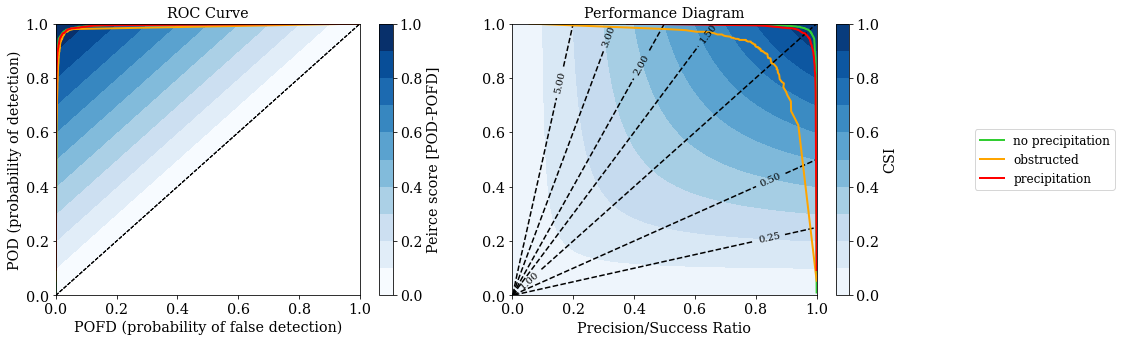

In [73]:
roc.performance_diagram(np.asarray([i.item() for i in p.labels]), yhat_proba)

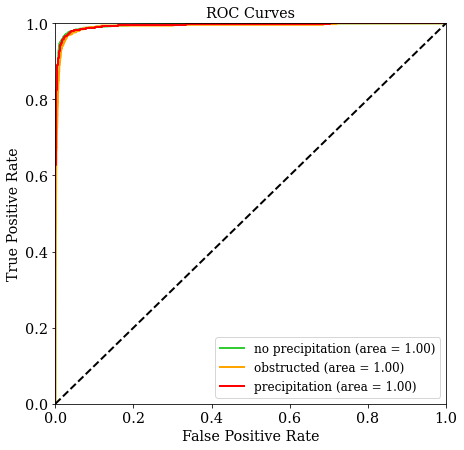

In [74]:
# confirm ROC curve is correct by plotting using sklearn
def calc_roc(labels, preds):
    """Compute Receiver operating characteristic (ROC)
    and area under curve (AUC) as if binary classification.
    Loop through each class to be used as positive label"""
    fpr, tpr, roc_auc = {}, {}, {}
    for i, c in enumerate(config.CLASS_NAMES):
        fpr[i], tpr[i], _ = roc_curve(labels, preds[:, i], pos_label=i)
        roc_auc = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

def plot_roc(fpr, tpr, roc_auc):
    colors = ['limegreen', 'orange', 'r']
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    for i, c in enumerate(config.CLASS_NAMES):
        ax.plot(fpr[i], tpr[i], lw=2, color=colors[i],
                label=f'{c} (area = {1:0.2f})'
                        ''.format(c, roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_title('ROC Curves')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

fpr, tpr, roc_auc = calc_roc([i.item() for i in p.labels], yhat_proba)
plot_roc(fpr, tpr, roc_auc)